In [1]:
!pip install torch torchvision kagglehub kaggle


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 50.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 59.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 54.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 72.9 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [37]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, utils


In [38]:
# --- Hyperparameters ---
IMAGE_SIZE = 32
CHANNELS = 3
BATCH_SIZE = 128
NUM_FEATURES = 128
Z_DIM = 200
LEARNING_RATE = 0.0005
EPOCHS = 1
BETA = 2000  # Weight on reconstruction loss
LOAD_MODEL = False
DEVICE = "cuda"

print(torch.cuda.is_available())


True


In [39]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("jessicali9530/celeba-dataset")

print("Path to dataset files:", path)


# Path to CelebA images
DATA_PATH = os.path.join(path, "img_align_celeba")

Path to dataset files: /root/.cache/kagglehub/datasets/jessicali9530/celeba-dataset/versions/2


In [59]:
#move dataset
import shutil
shutil.move(path, "/app/data")


'/app/data'

In [40]:
# Transforms: resize to 32x32 and normalize to [0,1]
transform = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    transforms.CenterCrop(IMAGE_SIZE),
    transforms.ToTensor(),
])

# Dataset & DataLoader
train_dataset = datasets.ImageFolder(
    root=os.path.dirname(DATA_PATH),  # Folder containing subfolder "img_align_celeba"
    transform=transform
)
# NB: If you have a specific folder structure, adjust accordingly

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2,
    drop_last=True
)

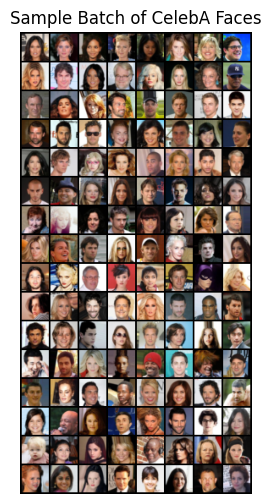

In [41]:
# Utility: show a batch of faces
def show_batch(images, title=""):
    grid_img = utils.make_grid(images, nrow=8)
    plt.figure(figsize=(12, 6))
    plt.imshow(grid_img.permute(1, 2, 0).cpu().numpy())
    plt.title(title)
    plt.axis("off")
    plt.show()

# Test: Show a sample batch
data_iter = iter(train_loader)
images, _ = next(data_iter)

show_batch(images, title="Sample Batch of CelebA Faces")

In [42]:
class Encoder(nn.Module):
    def __init__(self, z_dim=Z_DIM):
        super().__init__()
        self.z_dim = z_dim

        self.net = nn.Sequential(
            nn.Conv2d(CHANNELS, NUM_FEATURES, kernel_size=3, stride=2, padding=1),
            #batch normalisation
            nn.BatchNorm2d(NUM_FEATURES),
            #activation function
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(NUM_FEATURES, NUM_FEATURES, kernel_size=3, stride=2, padding=1),
             #batch normalisation
            nn.BatchNorm2d(NUM_FEATURES),
            #activation function
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(NUM_FEATURES, NUM_FEATURES, kernel_size=3, stride=2, padding=1),
            #batch normalisation
            nn.BatchNorm2d(NUM_FEATURES),
            #activation function
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(NUM_FEATURES, NUM_FEATURES, kernel_size=3, stride=2, padding=1),
            #batch normalisation
            nn.BatchNorm2d(NUM_FEATURES),
            #activation function
            nn.LeakyReLU(0.2, inplace=True),
        )

        # Flatten + produce mu & logvar
        # The output shape must be found dynamically
        # Hardcode if you know the shape after 4 conv layers
        # If IMAGE_SIZE=32 & 4 strided layers of stride=2 => output is 2x2
        self.flatten = nn.Flatten()
        # 2x2 out => size is (NUM_FEATURES * 2 * 2) = 128 * 2 * 2
        fc_in_features = NUM_FEATURES * (IMAGE_SIZE // 2**4) ** 2
        self.mu = nn.Linear(fc_in_features, z_dim)
        self.logvar = nn.Linear(fc_in_features, z_dim)

    def forward(self, x):
        x = self.net(x)
        x = self.flatten(x)
        mu = self.mu(x)
        logvar = self.logvar(x)
        return mu, logvar

In [43]:
class Sampling(nn.Module):
    def forward(self, mu, logvar):
        # Reparameterization trick
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

In [44]:
class Decoder(nn.Module):
    def __init__(self, z_dim=Z_DIM):
        super().__init__()
        self.z_dim = z_dim

        # Reverse of flatten
        fc_out_features = NUM_FEATURES * (IMAGE_SIZE // 2**4) ** 2
        self.fc = nn.Sequential(
            nn.Linear(z_dim, fc_out_features),
            #batch normalisation
            nn.BatchNorm1d(fc_out_features),
            #activation function
            nn.LeakyReLU(0.2,inplace=True)
        )

        self.deconv = nn.Sequential(
            # Reshape => (N, NUM_FEATURES, 2, 2) if 4 strided layers used
            # We'll reshape in forward()

            nn.ConvTranspose2d(NUM_FEATURES, NUM_FEATURES, kernel_size=3, stride=2, padding=1, output_padding=1),
            #batch normalisation
            nn.BatchNorm2d(NUM_FEATURES),
            #activation function
            nn.LeakyReLU(0.2, inplace=True),

            nn.ConvTranspose2d(NUM_FEATURES, NUM_FEATURES, kernel_size=3, stride=2, padding=1, output_padding=1),
            #batch normalisation
            nn.BatchNorm2d(NUM_FEATURES),
            #activation function
            nn.LeakyReLU(0.2, inplace=True),


            nn.ConvTranspose2d(NUM_FEATURES, NUM_FEATURES, kernel_size=3, stride=2, padding=1, output_padding=1),
            #batch normalisation
            nn.BatchNorm2d(NUM_FEATURES),
            #activation function
            nn.LeakyReLU(0.2, inplace=True),


            nn.ConvTranspose2d(NUM_FEATURES, CHANNELS, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Tanh()

        )

    def forward(self, z):
        x = self.fc(z)
        # Reshape -> (N, NUM_FEATURES, 2, 2)
        x = x.view(-1, NUM_FEATURES, (IMAGE_SIZE // 2**4), (IMAGE_SIZE // 2**4))
        x = self.deconv(x)
        return x

In [45]:
class VAE(nn.Module):
    def __init__(self, z_dim=Z_DIM):
        super().__init__()
        self.encoder = Encoder(z_dim)
        self.decoder = Decoder(z_dim)
        self.sampling = Sampling()

    def forward(self, x):
        mu, logvar = self.encoder(x)
        z = self.sampling(mu, logvar)
        recon = self.decoder(z)
        return mu, logvar, recon, z

In [46]:
def vae_loss_fn(x, recon, mu, logvar, beta=BETA):
    """
    x, recon: shape (N, CHANNELS, IMAGE_SIZE, IMAGE_SIZE)
    mu, logvar: shape (N, Z_DIM)
    """
    # 1) Reconstruction Loss (MSE or BCE)
    # - Following your TF code => MSELoss with a BETA factor
    recon_loss = F.mse_loss(recon, x, reduction="sum")

    # 2) KL Divergence
    # kl_loss ~ -0.5 * sum(1 + logvar - mu^2 - exp(logvar))
    kl = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    kl_loss = kl / x.size(0)

    total_loss = recon_loss + kl_loss * (beta / x.size(0))

    return total_loss, recon_loss, kl_loss



In [12]:
model = VAE(z_dim=Z_DIM).to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
for epoch in range(EPOCHS):
    model.train()
    total_loss_val = 0.0
    total_rec_val = 0.0
    total_kl_val = 0.0

    for batch_idx, (x, _) in enumerate(train_loader):
        x = x.to(DEVICE)
        optimizer.zero_grad()

        mu, logvar, recon, _ = model(x)
        loss, rec_loss, kl_loss = vae_loss_fn(x, recon, mu, logvar)

        optimizer.step()
        loss.backward()


        total_loss_val += loss.item()
        total_rec_val += rec_loss.item()
        total_kl_val += kl_loss.item()

    avg_loss = total_loss_val / len(train_loader)
    avg_rec = total_rec_val / len(train_loader)
    avg_kl = total_kl_val / len(train_loader)

    print(f"Epoch [{epoch+1}/{EPOCHS}] | Loss: {avg_loss:.4f} | Recon: {avg_rec:.4f} | KL: {avg_kl:.4f}")

Epoch [1/1] | Loss: 307097.8192 | Recon: 306675.9165 | KL: 27.0018


In [47]:
print("Loading existing model...")
state_dict = torch.load("./vae_face.pt", map_location=torch.device('cpu'))

# Create a new model instance (it might be on 'cpu' initially)
model = VAE(z_dim=Z_DIM)

# Load the parameters
model.load_state_dict(state_dict)

# Now move the model to the desired device (e.g., 'mps')
model.to(DEVICE)

Loading existing model...


<ipython-input-47-14bf1a37fde2>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load("./vae_face.pt", map_location=torch.device('cpu'))


VAE(
  (encoder): Encoder(
    (net): Sequential(
      (0): Conv2d(3, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
      (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): LeakyReLU(negative_slope=0.2, inplace=True)
      (6): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (8): LeakyReLU(negative_slope=0.2, inplace=True)
      (9): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (10): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (11): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (flatten): Flatten(start_dim=1, end_

In [48]:


model.eval()

VAE(
  (encoder): Encoder(
    (net): Sequential(
      (0): Conv2d(3, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
      (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): LeakyReLU(negative_slope=0.2, inplace=True)
      (6): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (8): LeakyReLU(negative_slope=0.2, inplace=True)
      (9): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (10): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (11): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (flatten): Flatten(start_dim=1, end_

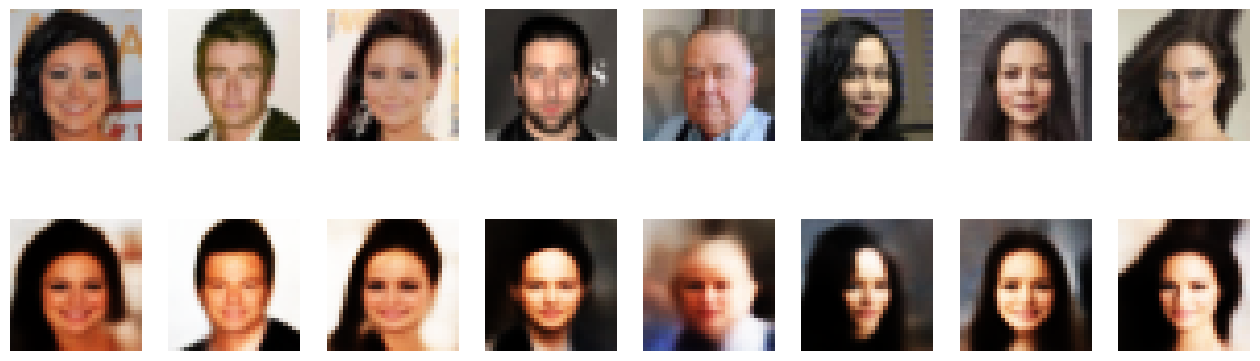

In [55]:

# Take a small batch to reconstruct
data_iter = iter(train_loader)
images, _ = next(data_iter)
images = images[:8].to(DEVICE)

with torch.no_grad():
    mu, logvar, recon,_ = model(images)

# Visualize original vs. reconstructions
def show_reconstructions(orig, recon):
    """
    Show original (top row) and reconstructions (bottom row) considering normalisation.
    """
    #unnormalize images
    recon = recon * 0.5 + 0.5
    fig = plt.figure(figsize=(16, 5))
    for i in range(8):
        ax = fig.add_subplot(2, 8, i+1)
        ax.axis("off")
        ax.imshow(orig[i].permute(1,2,0).cpu().numpy())
        ax = fig.add_subplot(2, 8, i+9)
        ax.axis("off")
        ax.imshow(recon[i].permute(1,2,0).cpu().numpy())
    plt.show()




show_reconstructions(images, recon)


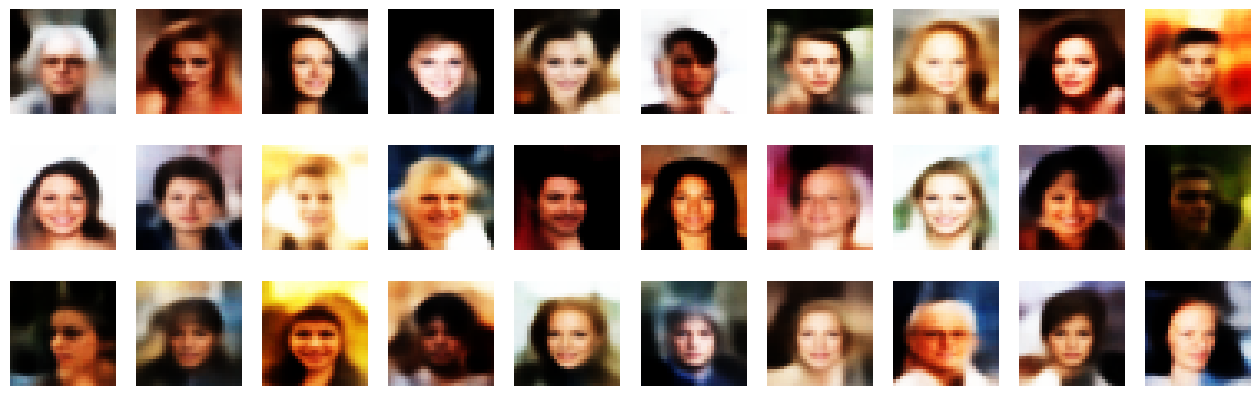

In [56]:
model.eval()

grid_width, grid_height = 10, 3
z_sample = torch.randn((grid_width*grid_height, Z_DIM)).to(DEVICE)

with torch.no_grad():
    recon = model.decoder(z_sample)

# Plot the generated images
def show_generated(recon, w=grid_width, h=grid_height):
    #unnormalize images
    recon = recon * 0.5 + 0.5
    recon = recon.cpu()
    fig = plt.figure(figsize=(16, 5))
    for i in range(w*h):
        ax = fig.add_subplot(h, w, i+1)
        ax.axis("off")
        ax.imshow(recon[i].permute(1,2,0).numpy())
    plt.show()

show_generated(recon)


In [61]:
# Suppose you have a CSV with attributes:
# /app/data/celeba-dataset/list_attr_celeba.csv
# Convert -1/1 => 0/1 to be more standard if needed.

# Load attributes
# Using pandas:
attributes = pd.read_csv("/app/data/list_attr_celeba.csv")

# Convert -1/1 to 0/1
print(attributes.columns)

Index(['image_id', '5_o_Clock_Shadow', 'Arched_Eyebrows', 'Attractive',
       'Bags_Under_Eyes', 'Bald', 'Bangs', 'Big_Lips', 'Big_Nose',
       'Black_Hair', 'Blond_Hair', 'Blurry', 'Brown_Hair', 'Bushy_Eyebrows',
       'Chubby', 'Double_Chin', 'Eyeglasses', 'Goatee', 'Gray_Hair',
       'Heavy_Makeup', 'High_Cheekbones', 'Male', 'Mouth_Slightly_Open',
       'Mustache', 'Narrow_Eyes', 'No_Beard', 'Oval_Face', 'Pale_Skin',
       'Pointy_Nose', 'Receding_Hairline', 'Rosy_Cheeks', 'Sideburns',
       'Smiling', 'Straight_Hair', 'Wavy_Hair', 'Wearing_Earrings',
       'Wearing_Hat', 'Wearing_Lipstick', 'Wearing_Necklace',
       'Wearing_Necktie', 'Young'],
      dtype='object')


In [70]:
# We now want to create a data loader that yields (image, label)
# Quick approach: we can build a custom dataset. This is a conceptual snippet.
LABEL = "Blond_Hair" or "Eyeglasses"
# Example minimal custom dataset
from PIL import Image

class CelebADataset(torch.utils.data.Dataset):
    def __init__(self, img_folder, attr_csv, label=LABEL, transform=None):
        self.transform = transform
        self.img_folder = img_folder
        self.df = attr_csv
        self.label = label
        # adjust if needed => if original images are named 000001.jpg, etc.

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        # Typically, row["image_id"] might hold the filename, e.g. 1.jpg or something
        file_name = row["image_id"]  # adapt to match your CSV
        path = os.path.join(self.img_folder, file_name)
        image = Image.open(path).convert("RGB")
        if self.transform:
            image = self.transform(image)

        label_val = row[self.label]
        # Convert -1 => 0, +1 => 1 if needed
        return image, label_val

# Then you create a DataLoader:
label_transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor()
])

img_folder = "/app/data/img_align_celeba/img_align_celeba"
label_dataset = CelebADataset(img_folder, attributes,
                              label=LABEL,
                              transform=label_transform)
label_loader = DataLoader(label_dataset, batch_size=BATCH_SIZE, shuffle=True)

# For attribute vector extraction, you'd:
# 1) Accumulate latent codes for positives and negatives
# 2) Subtract negative mean from positive mean
# 3) That difference is your attribute direction in latent space


In [71]:
import torch
import numpy as np

def get_vector_from_label(loader, vae, embedding_dim, label_name="Attribute", max_samples=10000):
    """
    Replicates the logic from 'get_vector_from_label' in Torch.

    loader: a PyTorch DataLoader yielding (images, labels) or (images, attribute).
            We assume attribute is in {-1, +1}.
    vae:    a VAE model with .encoder => returns (mu, logvar, z) or .forward => (mu, logvar, recon).
    embedding_dim: dimension of the latent space (z-dim).
    label_name: just for printing, e.g. "Blond_Hair".
    max_samples: how many positive or negative samples to gather before we stop.
        Returns: A direction vector in latent space (np.ndarray, shape=(embedding_dim,)).
    """
    device = next(vae.parameters()).device
    vae.eval()

    # Accumulators
    current_sum_POS = np.zeros(embedding_dim, dtype="float32")
    current_n_POS = 0
    current_mean_POS = np.zeros(embedding_dim, dtype="float32")

    current_sum_NEG = np.zeros(embedding_dim, dtype="float32")
    current_n_NEG = 0
    current_mean_NEG = np.zeros(embedding_dim, dtype="float32")

    current_vector = np.zeros(embedding_dim, dtype="float32")
    current_dist = 0.0

    print(f"label: {label_name}")
    print("images : POS move : NEG move : distance : Δ distance")

    # We'll iterate over the loader, collecting latents
    for images, attributes in loader:
        images = images.to(device)
        attributes = attributes.to(device)

        with torch.no_grad():
            recon, mu, logvar, z = vae(images)  # Suppose vae(...) => (mu, logvar, recon) or (mu, logvar, z)
            # If your VAE only returns (mu, logvar, recon), remove z => or do z = model.sampling(mu, logvar)
            # We'll assume the third output is z. Adjust as needed.

        # Move from GPU to CPU and to numpy
        z_np = z.detach().cpu().numpy()  # shape (N, embedding_dim)
        attr_np = attributes.detach().cpu().numpy()  # shape (N, )

        # Filter out positives/negatives
        mask_pos = np.where(attr_np == 1)[0]
        mask_neg = np.where(attr_np == -1)[0]

        z_POS = z_np[mask_pos]
        z_NEG = z_np[mask_neg]

        # Update partial sums
        if len(z_POS) > 0:
            current_sum_POS += np.sum(z_POS, axis=0)
            old_mean_POS = current_mean_POS.copy()
            current_n_POS += len(z_POS)
            current_mean_POS = current_sum_POS / current_n_POS
            movement_POS = np.linalg.norm(current_mean_POS - old_mean_POS)
        else:
            movement_POS = 0.0

        if len(z_NEG) > 0:
            current_sum_NEG += np.sum(z_NEG, axis=0)
            old_mean_NEG = current_mean_NEG.copy()
            current_n_NEG += len(z_NEG)
            current_mean_NEG = current_sum_NEG / current_n_NEG
            movement_NEG = np.linalg.norm(current_mean_NEG - old_mean_NEG)
        else:
            movement_NEG = 0.0

        # Current vector is difference
        current_vector = current_mean_POS - current_mean_NEG
        new_dist = np.linalg.norm(current_vector)
        dist_change = new_dist - current_dist

        print(f"{current_n_POS}    : {movement_POS:.3f}    : {movement_NEG:.3f}    : {new_dist:.3f}    : {dist_change:.3f}")

        current_dist = new_dist

        # Stopping conditions
        # 1) Enough samples
        if current_n_POS >= max_samples and current_n_NEG >= max_samples:
            pass
        # 2) Movement is small
        if (movement_POS + movement_NEG) < 0.08 and new_dist > 1e-8:
            current_vector /= new_dist
            print(f"Found the {label_name} vector")
            break

    return current_vector  # np array
feature_vec = get_vector_from_label(label_loader, model, embedding_dim=Z_DIM, label_name=LABEL)



label: Blond_Hair
images : POS move : NEG move : distance : Δ distance
16    : 3.419    : 1.463    : 3.673    : 3.673
38    : 2.573    : 0.940    : 2.617    : -1.056
58    : 1.188    : 0.591    : 2.366    : -0.251
78    : 0.919    : 0.400    : 2.245    : -0.120
102    : 0.765    : 0.309    : 2.090    : -0.155
125    : 0.562    : 0.242    : 1.969    : -0.121
149    : 0.502    : 0.183    : 1.896    : -0.073
164    : 0.330    : 0.194    : 1.871    : -0.025
176    : 0.262    : 0.175    : 1.820    : -0.050
195    : 0.311    : 0.151    : 1.801    : -0.020
212    : 0.302    : 0.122    : 1.759    : -0.042
230    : 0.244    : 0.123    : 1.731    : -0.029
253    : 0.268    : 0.104    : 1.725    : -0.006
274    : 0.226    : 0.095    : 1.724    : -0.001
284    : 0.141    : 0.101    : 1.699    : -0.025
300    : 0.180    : 0.093    : 1.692    : -0.007
320    : 0.192    : 0.083    : 1.683    : -0.010
331    : 0.154    : 0.075    : 1.683    : 0.001
350    : 0.171    : 0.072    : 1.678    : -0.005
365 

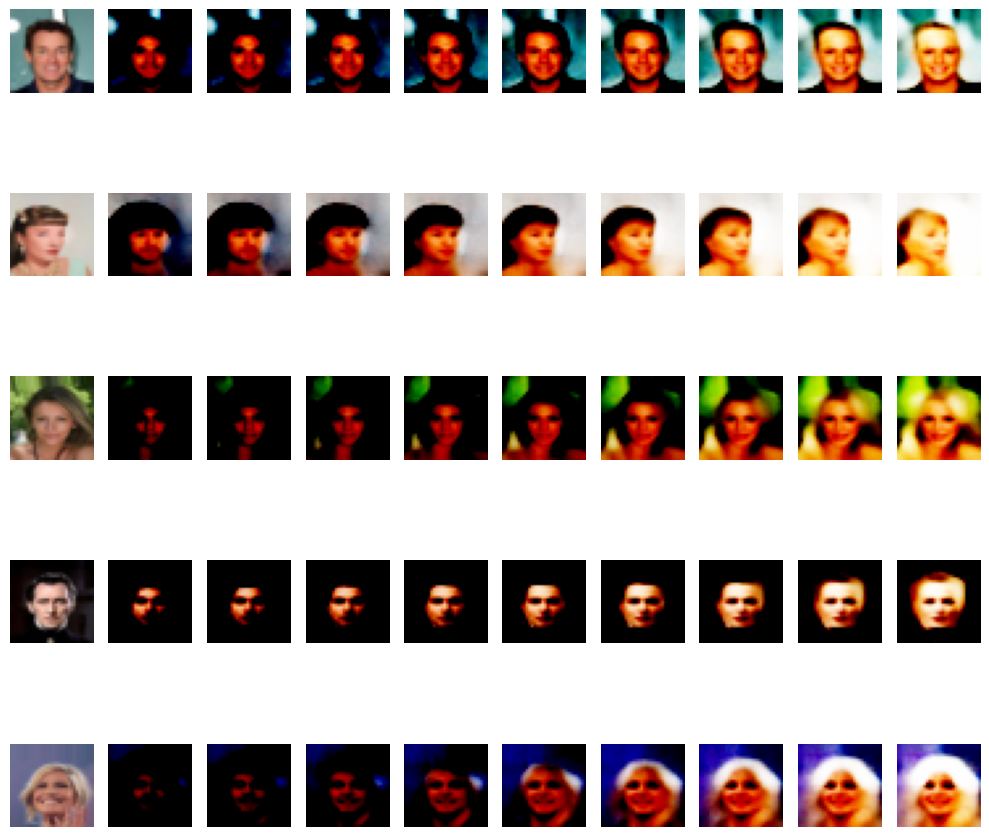

In [88]:
import matplotlib.pyplot as plt

def add_vector_to_images(loader, vae, feature_vec, factors=None):
    """
    Replicates 'add_vector_to_images' in PyTorch.

    loader: yields (images, labels).
    vae: a trained VAE with .encoder(...) => (mu, logvar, z) or .forward(...) => ...
    feature_vec: an np.array of shape (embedding_dim,).
    factors: list of multiples to add to the latent code. e.g. [-4, -3, -2, -1, 0, 1, 2, 3, 4].
    """
    if factors is None:
        factors = [-4, -3, -2, -1, 0, 1, 2, 3, 4]
    device = next(vae.parameters()).device
    vae.eval()

    # Take one batch from loader
    images, _ = next(iter(loader))  # or loader.__iter__() if repeated
    images = images.to(device)

    with torch.no_grad():
        _, mu, logvar, z = vae(images)

    # We'll show 5 images
    n_to_show = min(5, images.size(0))

    fig = plt.figure(figsize=(len(factors) + 1, n_to_show * 2))
    counter = 1

    for i in range(n_to_show):
        # Original image
        orig_img = images[i].detach().cpu().permute(1,2,0).numpy()
        ax = fig.add_subplot(n_to_show, len(factors) + 1, counter)
        counter += 1
        ax.axis("off")
        ax.imshow(orig_img)

        # For each factor
        base_z = z[i].detach().cpu().numpy()  # shape (embedding_dim,)
        for f in factors:
            changed_z = base_z + feature_vec * f
            changed_z_torch = torch.from_numpy(changed_z).unsqueeze(0).float().to(device)  # (1, z_dim)

            with torch.no_grad():
                recon = vae.decoder(changed_z_torch)  # shape (1, C, H, W)
                #unnormalize
                recon_img = recon[0].detach().cpu().permute(1,2,0).numpy()

            ax = fig.add_subplot(n_to_show, len(factors) + 1, counter)
            counter += 1
            ax.axis("off")
            ax.imshow(recon_img)

    plt.tight_layout()
    plt.show()
# 2) Add vector to images
add_vector_to_images(label_loader, model, feature_vec)

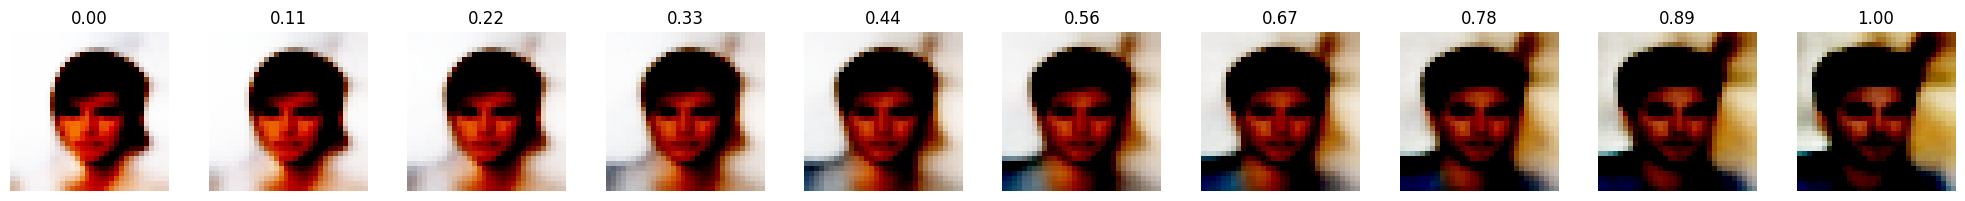

In [89]:
def morph_faces(loader, vae, steps=10):
    """
    Replicates 'morph_faces' logic in PyTorch.

    loader: yields (images, labels).
    vae: trained VAE.
    steps: how many interpolation steps to show.
    """
    device = next(vae.parameters()).device
    vae.eval()

    # Take one batch, pick first 2 images
    images, _ = next(iter(loader))
    images = images[:2].to(device)  # shape (2, C, H, W)
    if images.size(0) < 2:
        print("Not enough images in the batch to morph.")
        return

    with torch.no_grad():
        _,mu, logvar, z = vae(images)  # shape (2, z_dim)

    zA = z[0].detach().cpu().numpy()
    zB = z[1].detach().cpu().numpy()

    factors = np.linspace(0, 1, steps)
    plt.figure(figsize=(2*steps, 2))

    # show image A on the far left
    idx = 1
    for alpha in factors:
        inter_z = zA * (1 - alpha) + zB * alpha
        inter_z_torch = torch.from_numpy(inter_z).unsqueeze(0).float().to(device)
        with torch.no_grad():
            recon = vae.decoder(inter_z_torch)  # shape (1, C, H, W)
        recon_img = recon[0].detach().cpu().permute(1,2,0).numpy()

        ax = plt.subplot(1, steps, idx)
        idx += 1
        ax.imshow(recon_img)
        ax.set_title(f"{alpha:.2f}")
        ax.axis("off")

    plt.tight_layout()
    plt.show()
# 3) Morph two faces
morph_faces(label_loader, model, steps=10)